# Anomoly prediction for indycar dataset with LSTM 

In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import math
import random  
from sklearn.metrics import mean_squared_error
random.seed(1) 

### Read the cleaned dataset

In [2]:
# original data has already index, so index_col=0
clean_dataset = pd.read_excel('telemetry_cleaned.xlsx', index_col=0)  

In [3]:
clean_dataset.head(5)

,car_number,time,speed,rpm,distance,speed_scaled,rpm_scaled
0,1,0,NaN,NaN,NaN,NaN,NaN
1,1,1,NaN,NaN,NaN,NaN,NaN
2,1,2,NaN,NaN,NaN,NaN,NaN
3,1,3,NaN,NaN,NaN,NaN,NaN
4,1,4,NaN,NaN,NaN,NaN,NaN


In [4]:
car_numbers = clean_dataset.car_number.unique()
car_numbers

array([ 1,  3,  4,  6,  7,  9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 59, 60, 64, 66, 88, 98])

### Eevery car has `7` features (columns), total `33*11586` rows

In [5]:
# convert NaN to zero, and then matrix

dataset = clean_dataset.fillna(0).values 

In [6]:
dataset.shape

(382338, 7)

In [7]:
new_data = np.zeros((dataset.shape[0], 2), dtype=np.float)                

In [8]:
# select speed and distance as features for 33 cars  

new_data[:,0] = dataset[:,2]  
new_data[:,1] = dataset[:,4]

In [9]:
new_data.shape

(382338, 2)

In [10]:
# save scaled dataset

# pd.DataFrame(scaled).to_excel("scaled.xlsx") 

## Use look_back ( timestep ) to create dataset 

In [11]:
from sklearn.preprocessing import MinMaxScaler

# normalization of dataset
scaler = MinMaxScaler()
scaled = scaler.fit_transform(new_data)   # must scaled before create dataset

In [12]:
# create the X and Y with "look_back" 

def create_dataset(used_dataset, look_back):
    
    # scaled = scaler.fit_transform(used_dataset) 
    
    data_x, data_y = [], []
    for i in range( len(used_dataset)-look_back-1):
        temp = used_dataset[i:(i+look_back), :]
        temp = np.reshape(temp, (temp.shape[0]*temp.shape[1], )) # convert matrix to vector
        data_x.append(temp)
        data_y.append(used_dataset[i+look_back,0])

    return np.array(data_x), np.array(data_y)


## Use 10% as trainning, and select speed and distance as features

In [13]:
look_back = 50  # timestep

train_size = int( 0.1*scaled.shape[0] ) 
test_size = int(0.05*scaled.shape[0] )

x_train, y_train = create_dataset( scaled[:train_size,:], look_back )
x_test, y_test = create_dataset( scaled[train_size:(train_size+test_size),:], look_back)

In [14]:
print (x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(38182, 100) (19065, 100) (38182,) (19065,)


In [15]:
# 2 features !!!!!!!

features = 2  

In [16]:
x_train = x_train.reshape(x_train.shape[0], look_back, features)
x_test = x_test.reshape(x_test.shape[0], look_back, features)

In [17]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.
/Users/yafeiwang/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/yafeiwang/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/yafeiwang/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/yafeiwang/opt/anaconda3/l

In [18]:
model = Sequential()

model.add(LSTM(32, input_shape=(look_back, features), return_sequences=True))
#model.add(keras.layers.Dropout(rate=0.2))

model.add(LSTM(32))
#model.add(keras.layers.Dropout(rate=0.2))

model.add(Dense(1))

model.compile(loss='mae', optimizer='adam', metrics=["acc"]) # metrics is meaningless here

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 32)            4480      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 12,833
Trainable params: 12,833
Non-trainable params: 0
_________________________________________________________________


In [20]:
# if you want to see input shapes for the  layers
for layer in model.layers:
    print( layer.name, layer.input_shape)

lstm_1 (None, 50, 2)
lstm_2 (None, 50, 32)
dense_1 (None, 32)


In [21]:
# validation_data would override validation_split   

history = model.fit(x_train, y_train, validation_data = (x_test,y_test), epochs=50, batch_size=100, shuffle=False)

Instructions for updating:
Use tf.cast instead.
Train on 38182 samples, validate on 19065 samples
Epoch 1/50
38182/38182 [==============================] - 15s 402us/step - loss: 0.0592 - acc: 0.1250 - val_loss: 0.0701 - val_acc: 0.0451
Epoch 2/50
38182/38182 [==============================] - 15s 386us/step - loss: 0.0342 - acc: 0.1256 - val_loss: 0.0529 - val_acc: 0.0454
Epoch 3/50
38182/38182 [==============================] - 15s 392us/step - loss: 0.0291 - acc: 0.1259 - val_loss: 0.0278 - val_acc: 0.0457
Epoch 4/50
38182/38182 [==============================] - 15s 396us/step - loss: 0.0233 - acc: 0.1260 - val_loss: 0.0232 - val_acc: 0.0458
Epoch 5/50
38182/38182 [==============================] - 15s 396us/step - loss: 0.0193 - acc: 0.1262 - val_loss: 0.0781 - val_acc: 0.0459
Epoch 6/50
38182/38182 [==============================] - 15s 393us/step - loss: 0.0185 - acc: 0.1262 - val_loss: 0.0144 - val_acc: 0.0459
Epoch 7/50
38182/38182 [==============================] - 15s 387us/

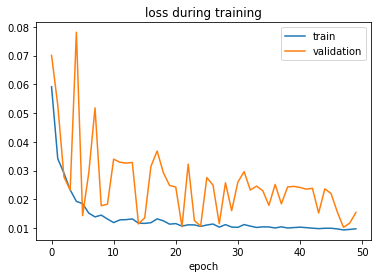

In [22]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
# plt.yticks([])
# plt.xticks([])
plt.title("loss during training")
plt.xlabel('epoch')
plt.savefig('loss during training.png')
plt.show()

In [23]:
# plt.plot(history.history['acc'], label='train accuracy')
# plt.plot(history.history['val_acc'], label='test accuracy')
# plt.legend()
# plt.title("accuracy during the training")
# plt.show()

In [24]:
predict_train = model.predict(x_train)
predict_test = model.predict(x_test)

In [25]:
print(predict_train.shape, predict_test.shape)

(38182, 1) (19065, 1)


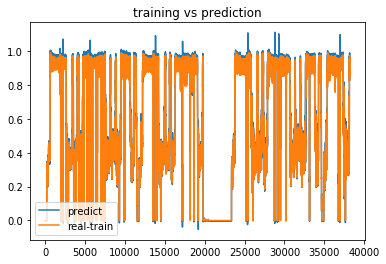

In [26]:
plt.plot(predict_train, label="predict")
plt.plot(y_train, label='real-train')
plt.title('training vs prediction')
plt.legend()
plt.show()

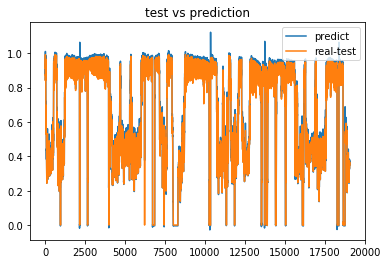

In [39]:
plt.plot(predict_test, label="predict")
plt.plot(y_test, label='real-test')
plt.title('test vs prediction')
plt.legend()
plt.savefig('test vs prediction (timestep=50).png')
plt.show()

In [28]:
# calculate root mean squared error

trainScore = math.sqrt(mean_squared_error(y_train, predict_train[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, predict_test[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.04 RMSE
Test Score: 0.03 RMSE


In [29]:
loss = np.abs(predict_test[:,0] - y_test)

anomaly_result = np.zeros(len(loss))
threshold = 0.08
anomaly_result[loss > threshold] = 1

In [30]:
loss.shape

(19065,)

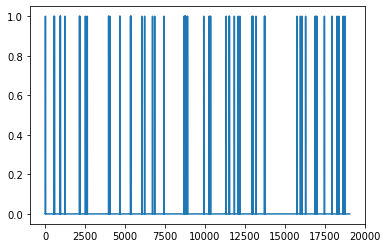

In [31]:
plt.plot(anomaly_result)

## Predict individual car 

In [40]:
def predict_car(car_id, look_back):
    
    car = clean_dataset[clean_dataset.car_number==car_id]
    new_car = car.fillna(0).values 
    car_data = np.zeros((new_car.shape[0], 2), dtype=np.float)  
    car_data[:,0] = new_car[:,2]  
    car_data[:,1] = new_car[:,4]
    
    # normalization of dataset
    scaled_car = scaler.fit_transform(car_data)  
    car_x, car_y = create_dataset(scaled_car, look_back)
    
    return car_x, car_y
    

In [41]:
car_id = 66

car_x, car_y = predict_car(car_id, look_back)
print(car_x.shape, car_y.shape)
car_x = car_x.reshape(car_x.shape[0], look_back, features)
print(car_x.shape, car_y.shape)

(11535, 100) (11535,)
(11535, 50, 2) (11535,)


In [42]:
car_predict = model.predict(car_x)

In [43]:
predictScore = math.sqrt(mean_squared_error(car_y, car_predict[:,0]))
print('Test Score: %.2f RMSE' % (predictScore))

Test Score: 0.04 RMSE


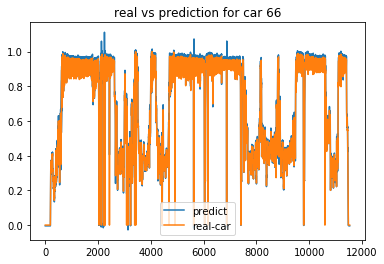

In [44]:
plt.plot(car_predict, label="predict")
plt.plot(car_y, label='real-car')
plt.title('real vs prediction for car {:d}'.format(car_id) )
plt.legend()
plt.savefig('real vs prediction for car {:d}.png'.format(car_id))
plt.show()

In [45]:
loss = np.abs(car_predict[:,0] - car_y)

anomaly_result = np.zeros(len(loss))
threshold = 0.10
anomaly_result[loss > threshold] = 1

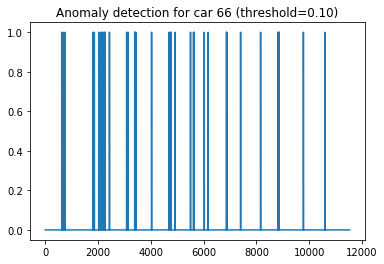

In [46]:
plt.plot(anomaly_result)
plt.title('Anomaly detection for car {:d} (threshold={:.2f})'.format(car_id, threshold) )
plt.savefig('Anomaly detection for car {:d} (threshold={:.2f}).png'.format(car_id, threshold) )

## More test plan

* More data ?
* Timestep ?
* Car number ?
* Features ?
* LSTM hidden layers and units number ?